# xgb reference
#   - https://xgboost.readthedocs.io/en/latest/python/python_intro.html
#       - https://xgboost.readthedocs.io/en/latest/python/python_api.html
#       - https://github.com/dmlc/xgboost/blob/v0.72/python-package/xgboost/sklearn.py
#   - https://xgboost.readthedocs.io/en/latest/parameter.html
#       - https://xgboost.readthedocs.io/en/latest/how_to/param_tuning.html
#   - https://github.com/dmlc/xgboost/tree/master/demo

In [ ]:
from notebooks import *
print_sys_info()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The potoo.default_magic_magic extension is already loaded. To reload it, use:
  %reload_ext potoo.default_magic_magic
platform:
  machine: x86_64
  node: Dan-B.local
  processor: i386
  release: 15.6.0
  system: Darwin
  version: 'Darwin Kernel Version 15.6.0: Thu Jun 23 18:25:34 PDT 2016; root:xnu-3248.60.10~1/RELEASE_X86_64'
cpu: 8
mem: 16g
swap: 22g


In [ ]:
# Load models
load = Load()
projection = Projection.load('peterson-v0-26bae1c', features=Features(load=load))

[00:04:05.218] DEBUG  Projection.load
  path: /Users/danb/hack/bubo/features/data/models/projection/peterson-v0-26bae1c.pkl


In [ ]:
# Select recs
#   1. countries: Filter recs to these countries
#   2. com_names: Filter recs to these species
#   3. recs_at_least: Filter species to those with at least this many recs
#   4. num_species: Sample this many of the species
#   5. num_recs: Sample this many recs per species
get_recs_stats = lambda df: dict(sp=df.species.nunique(), recs=len(df))
puts_stats = lambda desc: partial(tap, f=lambda df: print('%-15s %12s (sp/recs)' % (desc, '%(sp)s/%(recs)s' % get_recs_stats(df))))
countries, com_names = countries_na, com_names_ca  # 400k/9.4k -> 60k/1.1k -> 35k/334
# recs_at_least, num_species, num_recs = 100, 100, 100  # ca[334/35k -> 127/25k -> 100/21k -> 100/10k   -> 100/10k]
# recs_at_least, num_species, num_recs =  50, 100, 100  # ca[334/35k -> 224/32k -> 100/16k -> 100/ 9.0k -> 100/ 9.0k]
# recs_at_least, num_species, num_recs =   0, 100, 100  # ca[334/35k -> 334/35k -> 100/12k -> 100/ 6.8k ->  99/ 6.8k]
# recs_at_least, num_species, num_recs =   0, 168, 100  # ca[334/34k -> 334/34k -> 168/18k -> 168/11k   -> 167/11k]    # (old 'all')
# recs_at_least, num_species, num_recs =   0, 168,  20  # ca[334/34k -> 334/35k -> 168/18k -> 168/ 3.2k -> 167/ 3.2k]  # (old 'recs')
recs_at_least, num_species, num_recs =  20, 168,  20    # ca[334/35k -> 296/35k -> 168/20k -> 168/ 3.4k -> 168/ 3.4k]  # (old 'recs')
# recs_at_least, num_species, num_recs =  20, 50,  100  # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,  50   # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,  20   # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,  10   # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,  5    # Faster dev
xcs = (xc.metadata
    .pipe(puts_stats('all'))
    # 1. countries: Filter recs to these countries
    [lambda df: df.country.isin(countries)]
    .pipe(puts_stats('countries'))
    # 2. com_names: Filter recs to these species
    [lambda df: df.com_name.isin(com_names)]
    .pipe(puts_stats('com_names'))
    # Omit not-downloaded recs (should be few within the selected countries)
    [lambda df: df.downloaded]
    .pipe(puts_stats('(downloaded)'))
    # Remove empty cats for perf
    .pipe(df_remove_unused_categories)
    # 3. recs_at_least: Filter species to those with at least this many recs
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= recs_at_least].index)]
    .pipe(puts_stats('recs_at_least'))
    # 4. num_species: Sample this many of the species
    [lambda df: df.species.isin(df.species.drop_duplicates().pipe(lambda s: s.sample(n=min(len(s), num_species), random_state=0)))]
    .pipe(puts_stats('num_species'))
    # 5. num_recs: Sample this many recs per species
    #   - Remove empty cats else .groupby fails on empty groups
    .pipe(df_remove_unused_categories)
    .groupby('species').apply(lambda g: g.sample(n=min(len(g), num_recs), random_state=0))
    .pipe(puts_stats('num_recs'))
    # Drop species with <2 recs, else StratifiedShuffleSplit complains (e.g. 'TUVU')
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= 2].index)]
    .pipe(puts_stats('recs ≥ 2'))
    # Clean up for downstream
    .pipe(df_remove_unused_categories)
)
_recs_stats = get_recs_stats(xcs)
recs_stats = ', '.join(['%s[%s]' % (k, v) for k, v in _recs_stats.items()])
display(
    recs_stats,
    df_summary(xcs).T,
    xcs.sample(n=10, random_state=0).sort_values('species'),
)

all              9442/399859 (sp/recs)
countries         1148/59713 (sp/recs)
com_names          334/35236 (sp/recs)
(downloaded)       334/35232 (sp/recs)
recs_at_least      296/34846 (sp/recs)
num_species        168/19640 (sp/recs)


num_recs            168/3360 (sp/recs)
recs ≥ 2            168/3360 (sp/recs)


'sp[168], recs[3360]'

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
downloaded,bool,94080,3360,3360,1,NaN,NaN,True,True,True,True,True
species,category,178080,3360,3360,168,NaN,NaN,GWFG,GBTE,REVI,NOWA,AMGO
id,int64,94080,3360,3360,3360,213283.439,108055.964,1133,138144,193564,308285,416744
sci_name,category,227200,3360,3360,168,NaN,NaN,Anser albifrons,Gelochelidon nilotica,Vireo olivaceus,Parkesia noveboracensis,Spinus tristis
com_name,category,220320,3360,3360,168,NaN,NaN,Greater White-fronted Goose,Gull-billed Tern,Red-eyed Vireo,Northern Waterthrush,American Goldfinch
subspecies,object,169603,3360,3360,205,NaN,NaN,,,,,zaboria
recordist,object,211728,3360,3360,291,NaN,NaN,AJ Knue,Frank Lambert,Matthias Feuersenger,Peter Boesman,tetiaroa
country,object,203063,3360,3360,3,NaN,NaN,Canada,United States,United States,United States,United States
locality,object,316516,3360,3360,1740,NaN,NaN,"Bahía la Ventosa, Salina Cruz, Oaxaca","Desert Beeline Highway, Maricopa County, Arizona","May Lake, Yosemite NP, California","Sabine Nature Trail loop, Cameron Parish, Louisiana","west of Thorp, WA"


,,downloaded,species,id,sci_name,com_name,subspecies,recordist,country,locality,lat,lng,type,quality,date,time,license_type,license_detail,license,url,download
species,,,,,,,,,,,,,,,,,,,,,
COGA,205189,True,COGA,207451,Gallinula galeata,Common Gallinule,sandvicensis,Ross Gallardy,United States,"Kailua, Honolulu County, Hawaii",21.4,-158.0,call,B,2014-12-21 00:00:00,07:30,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/207451,//www.xeno-canto.org/207451/download
INDO,18832,True,INDO,398616,Columbina inca,Inca Dove,,Manuel Grosselet,Mexico,Lomas de Bezares Miguel Hidalgo Mexico city,19.4,-99.2,song,B,2018-01-07 00:00:00,08:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/398616,//www.xeno-canto.org/398616/download
EWPW,223194,True,EWPW,188611,Antrostomus vociferus,Eastern Whip-poor-will,,David Jonas Weber,United States,"Gravelly Hill Rd., Salem County, New Jersey",39.5,-75.4,song,C,2014-07-25 00:00:00,05:30,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/188611,//www.xeno-canto.org/188611/download
NUWO,113835,True,NUWO,301366,Picoides nuttallii,Nuttall's Woodpecker,,Denise Wight,United States,"Moraga, Contra Costa County, California",37.8,-122.0,"Hawk mobbing call, alarm call",C,2016-01-25 00:00:00,10:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/301366,//www.xeno-canto.org/301366/download
BBWO,80808,True,BBWO,335436,Picoides arcticus,Black-backed Woodpecker,,Lance A. M. Benner,United States,"Blackrock Trailhead, Tulare County, California",36.2,-118.0,"drumming, male",no score,2016-09-17 00:00:00,16:41,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/335436,//www.xeno-canto.org/335436/download
HUVI,117936,True,HUVI,297126,Vireo huttoni,Hutton's Vireo,,Paul Marvin,United States,"Kickapoo Cavern State Park, Brackettville, Texas",29.6,-100.0,song,C,2012-04-08 00:00:00,07:58,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/297126,//www.xeno-canto.org/297126/download
MGWA,89731,True,MGWA,326299,Geothlypis tolmiei,MacGillivray's Warbler,,Lance A. M. Benner,United States,"Buckhorn Campground, San Gabriel Mountains, Los Angeles County, California",34.3,-118.0,"male, song",no score,2016-06-28 00:00:00,10:49,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/326299,//www.xeno-canto.org/326299/download
PUFI,159786,True,PUFI,254326,Haemorhous purpureus,Purple Finch,,Iain,Canada,"Algonquin Highlands, Haliburton County, Ontario",45.3,-78.8,song,C,2015-06-27 00:00:00,11:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/254326,//www.xeno-canto.org/254326/download
CAFI,46804,True,CAFI,369971,Haemorhous cassinii,Cassin's Finch,,Eric DeFonso,United States,"Dunton Rd area, San Juan National Forest, Dolores County, Colorado",37.8,-108.0,song,A,2016-06-28 00:00:00,15:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/369971,//www.xeno-canto.org/369971/download


In [ ]:
xcs_paths = [
    ('xc', f'{data_dir}/xc/data/{row.species}/{row.id}/audio.mp3')
    for row in df_rows(xcs)
]
joblib.dump(xcs_paths, '/tmp/xcs_paths')  # In case you want to run load.recs in a terminal (it's long and verbose)
display(
    len(xcs_paths),
    # xcs_paths[:2],
)

3360

In [ ]:
# TODO Restore once:true after debug [but think carefully how once:true interacts with the once:false params above]
recs = load.recs(paths=xcs_paths)
display(
    df_summary(recs).T,
    recs[:5],
)

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
dataset,object,171360,3360,3360,1,NaN,NaN,xc,xc,xc,xc,xc
species,category,178080,3360,3360,168,NaN,NaN,GWFG,GBTE,REVI,NOWA,AMGO
species_com_name,category,219160,3360,3360,168,NaN,NaN,Greater White-fronted Goose,Gull-billed Tern,Red-eyed Vireo,Northern Waterthrush,American Goldfinch
species_query,object,178080,3360,3360,168,NaN,NaN,ACWO,CONI,LASP,RIRA,YRWA
duration_s,float64,80640,3360,3360,3054,5.430e+01,7.031e+01,0.697,14.4,31.8,65.4,940
samples_mb,float64,80640,3360,3360,3055,2.286e+00,2.958e+00,0.0293,0.604,1.34,2.76,39.5
samples_n,int64,94080,3360,3360,3055,1.198e+06,1.551e+06,15368,316510,701190,1444435,20731931
basename,object,181440,3360,3360,1,NaN,NaN,audio,audio,audio,audio,audio
species_longhand,category,242680,3360,3360,168,NaN,NaN,Greater White-fronted Goose - GWFG,Gull-billed Tern - GBTE,Red-eyed Vireo - REVI,Northern Waterthrush - NOWA,American Goldfinch - AMGO


,dataset,species,species_com_name,species_query,duration_s,samples_mb,samples_n,basename,species_longhand,id,path
0,xc,GWFG,Greater White-fronted Goose,GWFG,23.7,0.997,522850,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/149379/audio,xc/data/GWFG/149379/audio.mp3
1,xc,GWFG,Greater White-fronted Goose,GWFG,18.3,0.770,403780,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/276918/audio,xc/data/GWFG/276918/audio.mp3
2,xc,GWFG,Greater White-fronted Goose,GWFG,45.0,1.890,991296,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/210100/audio,xc/data/GWFG/210100/audio.mp3
3,xc,GWFG,Greater White-fronted Goose,GWFG,17.6,0.738,387072,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/323113/audio,xc/data/GWFG/323113/audio.mp3
4,xc,GWFG,Greater White-fronted Goose,GWFG,24.0,1.010,528142,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/276919/audio,xc/data/GWFG/276919/audio.mp3


In [ ]:
# Fast-and-cheap version (<1s) of the plot below (7s)
(recs
    .species_longhand.value_counts().sort_index()
    .reset_index().rename(columns={'index': 'species_longhand', 'species_longhand': 'num_recs'})
    .assign(num_recs=lambda df: df.num_recs.map(lambda n: '%s /%s' % ('•' * int(n / df.num_recs.max() * 60), df.num_recs.max())))
)

,species_longhand,num_recs
0,Greater White-fronted Goose - GWFG,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
1,Gadwall - GADW,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
2,American Wigeon - AMWI,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
3,Mallard - MALL,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
4,Green-winged Teal - GWTE,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
5,California Quail - CAQU,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
6,Gambel's Quail - GAQU,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
7,Sooty Grouse - SOGR,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
8,Wild Turkey - WITU,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
9,Common Loon - COLO,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20


In [ ]:
(recs
    .assign(species=lambda df: df.species_longhand)
    .assign(count=1)
    # 0-fill all (species, dataset) combinations to create empty placeholders for missing bars
    .pipe(lambda df: df.append(
        pd.DataFrame([
            dict(species=species, dataset=dataset, duration_s=0)
            for species in df.species.unique()
            for dataset in df.dataset.unique()
        ])
        .astype({'species': df.species.dtype})
    ))
    .groupby(['dataset', 'species'])[['count', 'duration_s']].sum().reset_index()
    # Order by species by taxo
    .pipe(df_reverse_cat, 'species')
    # Order by species by count
    # .pipe(df_ordered_cat, species=lambda df: df.sort_values('count').species)
    .pipe(pd.melt, id_vars=['dataset', 'species'], value_vars=['count', 'duration_s'])
    .pipe(df_remove_unused_categories)
    .pipe(ggplot, aes(x='species', y='value', fill='dataset', color='dataset'))
    + coord_flip()
    + geom_bar(stat='identity', position=position_dodge(), width=.8)
    + facet_wrap('variable', nrow=1, scales='free')
    + xlab('')
    + ylab('')
    + scale_fill_cmap_d(mpl.cm.tab10)
    + scale_color_cmap_d(mpl.cm.tab10)
    + theme(panel_spacing=2.5)
    + theme_figsize(width=18, aspect_ratio=4/1)
    + ggtitle(f'recs: Total (count, duration_s) per (species, dataset)')
)

[skip]

In [ ]:
# Add .feat
recs = projection.transform(recs)

In [ ]:
# Make data
X, y = Search.Xy(recs)
(n, p) = X.shape
classes = np.sort(np.unique(y))
n_classes = len(classes)
yi = lambda y: np.array([list(classes).index(_y) for _y in y])  # xgb api wants num labels, not str labels
(X_train, X_test, y_train, y_test) = sk.model_selection.train_test_split(
    X, y,
    test_size=0.2,
    random_state=0,
)
display(
    (X.shape, y.shape),
    y[:5],
    (X_train.shape, y_train.shape),
    (X_test.shape, y_test.shape),
)

((3360, 1500), (3360,))

array(['GWFG', 'GWFG', 'GWFG', 'GWFG', 'GWFG'], dtype='<U4')

((2688, 1500), (2688,))

((672, 1500), (672,))

In [ ]:
# Make xgb data
xgb_train = xgb.DMatrix(X_train, yi(y_train))
xgb_test = xgb.DMatrix(X_test, yi(y_test))

In [ ]:
# Params for random forest
#   - Multiclass ex: https://github.com/dmlc/xgboost/blob/master/demo/multiclass_classification/train.py
#   - RF ex: https://github.com/szilard/benchm-ml/blob/master/z-other-tools/6-xgboost.R
#   - RF ex: https://github.com/dmlc/xgboost/blob/v0.72/R-package/vignettes/discoverYourData.Rmd#special-note-what-about-random-forests
xgb_train_kwargs = dict(
    num_boost_round=1,
)
xgb_params = dict(
    # https://xgboost.readthedocs.io/en/latest/parameter.html

    # Boring
    seed=0,
    # silent=0,  # FIXME silent=0 causes annoying atom notifications instead of ipykernel stdout/stderr (because subprocess?)
    silent=1,

    # Multiclass
    #   - softmax: .predict will return (len(X_test),) like sk .predict
    #   - softprob: .predict will return (len(X_test), n_classes) like sk .predict_proba [https://github.com/dmlc/xgboost/issues/101]
    #   - Both require num_class
    objective='multi:softprob',
    num_class=n_classes,

    # Random forest
    eta=1,
    # num_parallel_tree=100,
    num_parallel_tree=1,  # XXX Debug
    subsample=1 - 1 / np.e,  # Approximate the instance exposure (without replacement) we'd get from bootstrap (with replacement)
    colsample_bylevel=np.sqrt(p) / p,  # sqrt(p) features for classification, p/3 features for regression
    # colsample_bytree=np.sqrt(p) / p,  # XXX Pretty sure we want bylevel, not bytree

    # Tree tuning
    #   - TODO
    # max_depth=1000000,
    # max_depth=1000,
    # max_depth=100,
    max_depth=50,
    # max_depth=20,
    # max_depth=10,
    # max_depth=0,
    #   - Default: 6
    #   - 0 means no limit
    min_child_weight=0,
    # min_child_weight=.0001,
    # min_child_weight=.001,
    # min_child_weight=.01,
    # min_child_weight=.1,
    # min_child_weight=.5,
    # min_child_weight=1,
    #   - Default: 1
    tree_method='exact',
    #   - Default: 'auto'
    #   - 'exact' | 'approx' | 'hist'
    #   - Quick takeaways
    #       - 'exact'/'approx' take comparable duration, 'hist' takes _way_ longer
    #       - Stick with 'exact'/'auto' for now

    # TODO "A typical value to consider: sum(negative cases) / sum(positive cases)"
    # scale_pos_weight=((168 - 1) * 20) / 20,

    # HACK Debug: hard-disable pruning, to make sure it's not causing our max_depth problem
    updater='grow_colmaker',

)

evals_result = {}
train_s, gbm = timed(lambda: xgb.train(
    **xgb_train_kwargs,
    params=xgb_params,
    dtrain=xgb_train,
    evals=[(xgb_train, 'train'), (xgb_test, 'test')],
    evals_result=evals_result,
    verbose_eval=1,
))
display(
    evals_result,  # evals_result['test']['multi_logloss']: np.ndarray, same as the verbose output
)

[0]	train-merror:0.408854	test-merror:0.93006


{'train': {'merror': [0.408854]}, 'test': {'merror': [0.93006]}}

In [ ]:
# Example using sklearn api
# search = Search(projection=projection,
#     classifier=f'cls: xgbm, n_estimators: 2',
# )
# search.fit(X_train, y_train)

In [ ]:
# Model size
gbm_pickle = joblib_dumps(gbm)
display(
    humanize.naturalsize(len(gbm_pickle)),  # (Dumps to an efficient binary format, unlike lgb's redundant text format)
    humanize.naturalsize(len(gzip.compress(gbm_pickle))),
)

'30.0 MB'

'7.4 MB'

In [ ]:
# Tree stats
gbm.dump_model('/tmp/gbm.txt', with_stats=True)  # Human readable
tree_strs = gbm.get_dump(with_stats=True)
tree_node_strs = [[node for node in tree.rstrip('\n').split('\n')] for tree in tree_strs]
tree_stats = (
    DF(
        OrderedDict(
            n_trees=n_trees,
            tree_i=tree_i,
            n_nodes=n_nodes,
            node_i=node_i,
            is_leaf=':leaf=' in node_str,
            node_depth=ilen(takewhile(lambda x: x == '\t', node_str)),
            node_str=node_str,
        )
        for tree_i, n_trees, node_strs in enumerate_with_n(tree_node_strs)
        for node_i, n_nodes, node_str in enumerate_with_n(node_strs)
    )
    .groupby(['tree_i']).apply(lambda g: g.assign(
        max_depth=g.node_depth.max(),
        n_leaves=g.is_leaf.sum(),
    )).reset_index(drop=True)
    .pipe(df_reorder_cols,
        first=['n_trees', 'tree_i', 'n_nodes', 'n_leaves', 'max_depth'],
        last=['node_str'],
    )
)
print('\n'.join('\n'.join(tree_strs).split('\n')[:10]))
display(
    df_summary(tree_stats),
    tree_stats[:10],
)

0:[f201<-0.125396669] yes=1,no=2,missing=1,gain=4.90637732,cover=19.9519558
	1:leaf=-0.00454611098,cover=9.39611721
	2:[f1337<2.20325708] yes=3,no=4,missing=3,gain=14.1302309,cover=10.5558395
		3:[f63<0.00835909694] yes=5,no=6,missing=5,gain=10.3957033,cover=1.36089861
			5:leaf=-0.00210872875,cover=0.721867919
			6:[f149<-0.0412669778] yes=9,no=10,missing=9,gain=4.76318789,cover=0.639030635
				9:[f15<-0.0808333158] yes=15,no=16,missing=15,gain=4.65716505,cover=0.43785432
					15:leaf=-0.000670638052,cover=0.153840706
					16:[f625<0.46862632] yes=21,no=22,missing=21,gain=3.00420642,cover=0.284013629
						21:[f1148<1.10868931] yes=25,no=26,missing=25,gain=2.9276278,cover=0.201176316


,n_trees,tree_i,n_nodes,n_leaves,max_depth,node_i,is_leaf,node_depth,node_str
dtype,int64,int64,int64,int64,int64,int64,bool,int64,object
sizeof,21309568,21309436,21309568,21309568,21309568,21242368,19821056,21242368,90327503
len,761056,761056,761056,761056,761056,761056,761056,761056,761056
count,761056,761056,761056,761056,761056,761056,761056,761056,761056
nunique,1,16800,49,49,20,213,2,51,394067
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,16800,0,7,4,3,0,False,0,"\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t100:leaf=0.0556887649,cover=0.0710034072"
25%,16800,4289,29,15,8,11,False,3,"\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t62:[f55<-0.646858573] yes=63,no=64,missing=63,gain=1.50511266e-06,cover=0.0710034072"
50%,16800,8695,105,53,50,23,True,6,"\t\t\t\t\t\t19:leaf=-0.000116295167,cover=0.0236678012"


,n_trees,tree_i,n_nodes,n_leaves,max_depth,node_i,is_leaf,node_depth,node_str
0,16800,0,33,17,10,0,False,0,"0:[f201<-0.125396669] yes=1,no=2,missing=1,gain=4.90637732,cover=19.9519558"
1,16800,0,33,17,10,1,True,1,"\t1:leaf=-0.00454611098,cover=9.39611721"
2,16800,0,33,17,10,2,False,1,"\t2:[f1337<2.20325708] yes=3,no=4,missing=3,gain=14.1302309,cover=10.5558395"
3,16800,0,33,17,10,3,False,2,"\t\t3:[f63<0.00835909694] yes=5,no=6,missing=5,gain=10.3957033,cover=1.36089861"
4,16800,0,33,17,10,4,True,3,"\t\t\t5:leaf=-0.00210872875,cover=0.721867919"
5,16800,0,33,17,10,5,False,3,"\t\t\t6:[f149<-0.0412669778] yes=9,no=10,missing=9,gain=4.76318789,cover=0.639030635"
6,16800,0,33,17,10,6,False,4,"\t\t\t\t9:[f15<-0.0808333158] yes=15,no=16,missing=15,gain=4.65716505,cover=0.43785432"
7,16800,0,33,17,10,7,True,5,"\t\t\t\t\t15:leaf=-0.000670638052,cover=0.153840706"
8,16800,0,33,17,10,8,False,5,"\t\t\t\t\t16:[f625<0.46862632] yes=21,no=22,missing=21,gain=3.00420642,cover=0.284013629"
9,16800,0,33,17,10,9,False,6,"\t\t\t\t\t\t21:[f1148<1.10868931] yes=25,no=26,missing=25,gain=2.9276278,cover=0.201176316"


In [ ]:
# Tree viz
for tree_i in range(1):
    display(xgb.to_graphviz(gbm, num_trees=tree_i))

[skip]

In [ ]:
y_pred = gbm.predict(xgb_test); y_pred
test_evals = SearchEvals(y=y_test, classes=classes, y_scores=y_pred)
display(
    X_test.shape,
    y_pred.shape,
    test_evals.score(),
    test_evals.coverage_error(),
    # test_evals.coverage_errors(),
)

(672, 1500)

(672, 168)

numpy.float64(-8.0)

numpy.float64(8.0)

In [ ]:
# Train time
'%.3fs' % train_s

'106.010s'

In [ ]:
(tree_stats
    [:10]
)

,n_trees,tree_i,n_nodes,n_leaves,max_depth,node_i,is_leaf,node_depth,node_str
0,16800,0,33,17,10,0,False,0,"0:[f201<-0.125396669] yes=1,no=2,missing=1,gain=4.90637732,cover=19.9519558"
1,16800,0,33,17,10,1,True,1,"\t1:leaf=-0.00454611098,cover=9.39611721"
2,16800,0,33,17,10,2,False,1,"\t2:[f1337<2.20325708] yes=3,no=4,missing=3,gain=14.1302309,cover=10.5558395"
3,16800,0,33,17,10,3,False,2,"\t\t3:[f63<0.00835909694] yes=5,no=6,missing=5,gain=10.3957033,cover=1.36089861"
4,16800,0,33,17,10,4,True,3,"\t\t\t5:leaf=-0.00210872875,cover=0.721867919"
5,16800,0,33,17,10,5,False,3,"\t\t\t6:[f149<-0.0412669778] yes=9,no=10,missing=9,gain=4.76318789,cover=0.639030635"
6,16800,0,33,17,10,6,False,4,"\t\t\t\t9:[f15<-0.0808333158] yes=15,no=16,missing=15,gain=4.65716505,cover=0.43785432"
7,16800,0,33,17,10,7,True,5,"\t\t\t\t\t15:leaf=-0.000670638052,cover=0.153840706"
8,16800,0,33,17,10,8,False,5,"\t\t\t\t\t16:[f625<0.46862632] yes=21,no=22,missing=21,gain=3.00420642,cover=0.284013629"
9,16800,0,33,17,10,9,False,6,"\t\t\t\t\t\t21:[f1148<1.10868931] yes=25,no=26,missing=25,gain=2.9276278,cover=0.201176316"


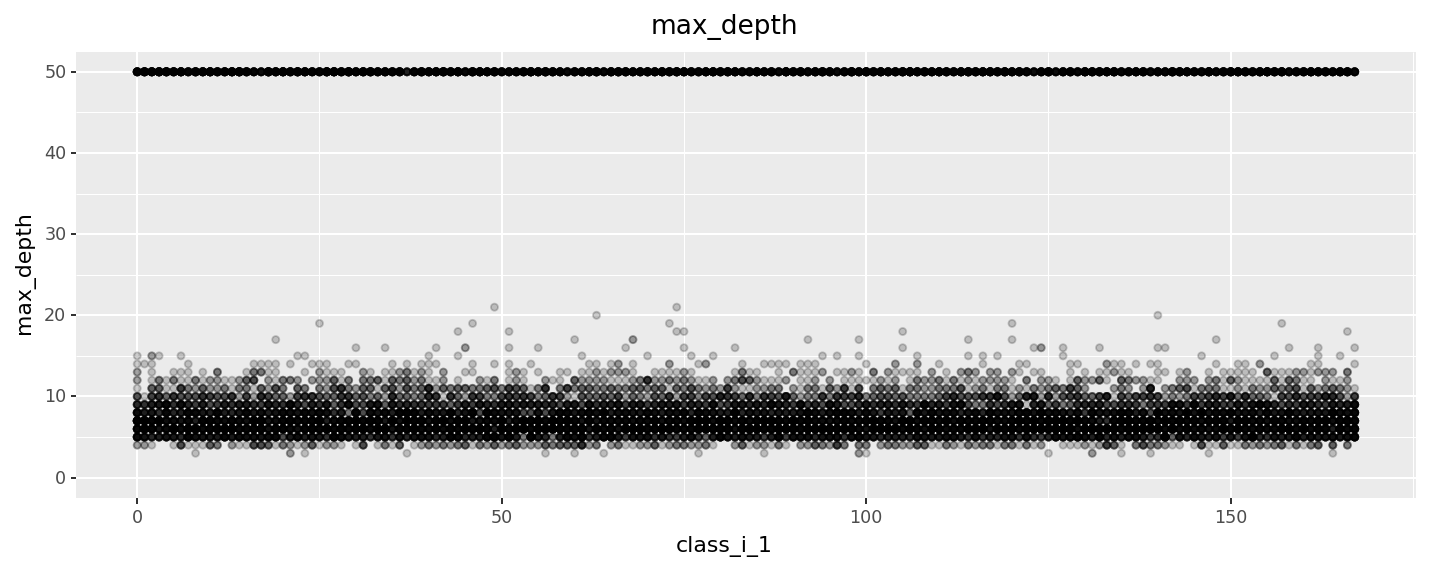

<ggplot: (-9223372036529846745)>

In [ ]:
# TODO Is the bimodal max_depth correlated with class? (Or par, while we're at it?)
#   - [Nope, I see no correlations...]
(tree_stats
    [['tree_i', 'max_depth']].drop_duplicates()
    .assign(
        # TODO Are the trees (par, class) or (class, par)? -- try both
        par_i_0=lambda df: df.tree_i % xgb_params['num_parallel_tree'],
        class_i_0=lambda df: df.tree_i // xgb_params['num_parallel_tree'],
        par_i_1=lambda df: df.tree_i // n_classes,
        class_i_1=lambda df: df.tree_i % n_classes,
    )
    # [-20:]
    .pipe(ggplot)
    + aes(y='max_depth')
    # + aes(x='class_i_0')
    + aes(x='class_i_1')
    # + aes(x='par_i_0')
    # + aes(x='par_i_1')
    + geom_point(alpha=.2)
    + expand_limits(y=0)
    + theme_figsize('inline_short')
    + ggtitle('max_depth')
)

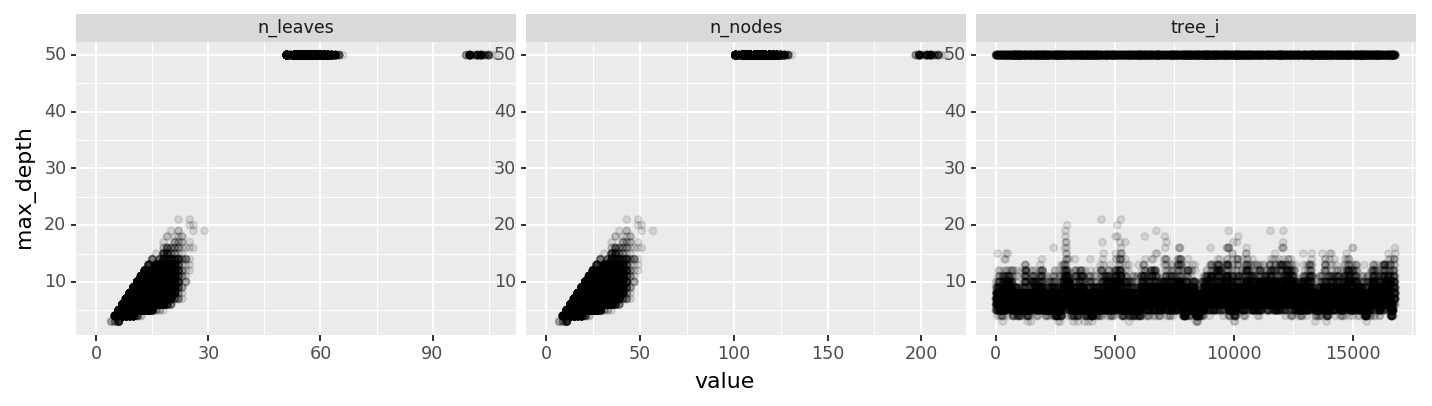

<ggplot: (-9223372036535648424)>

In [ ]:
# TODO Is the bimodal max_depth correlated with other tree stats?
(tree_stats
    [['tree_i', 'n_nodes', 'n_leaves', 'max_depth']].drop_duplicates()
    .pipe(lambda df: pd.melt(df, id_vars=['max_depth'], value_vars=list(set(df.columns) - {'max_depth'})))
    # .pipe(puts, f=lambda df: df[:10])
    .pipe(ggplot)
    + aes(y='max_depth', x='value')
    + facet_wrap('variable', scales='free', nrow=1)
    + geom_point(alpha=.1)
    + expand_limits(x=0)
    + theme_figsize('inline')
)

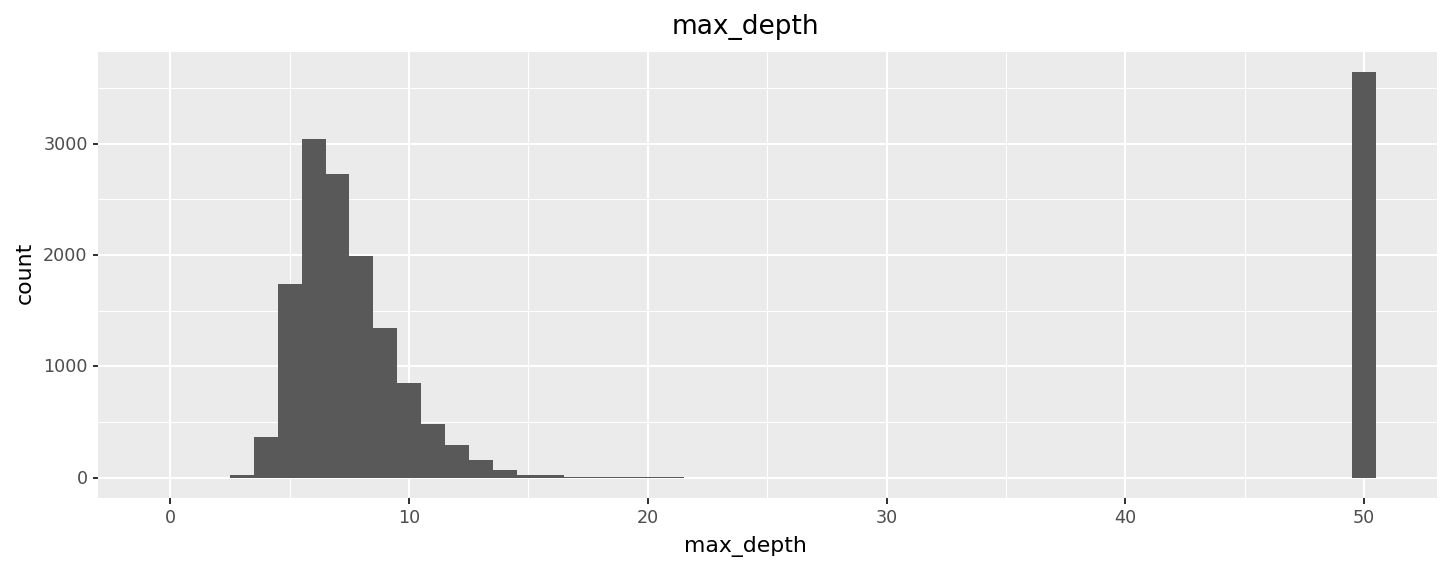

<ggplot: (-9223372036529847843)>

In [ ]:
(tree_stats
    .groupby(['tree_i']).apply(lambda g: g[['tree_i', 'max_depth']].drop_duplicates()).reset_index(drop=True)
    .pipe(ggplot)
    + aes(x='max_depth')
    + geom_histogram(binwidth=1)
    + expand_limits(x=0)
    + theme_figsize('inline_short')
    + ggtitle('max_depth')
)

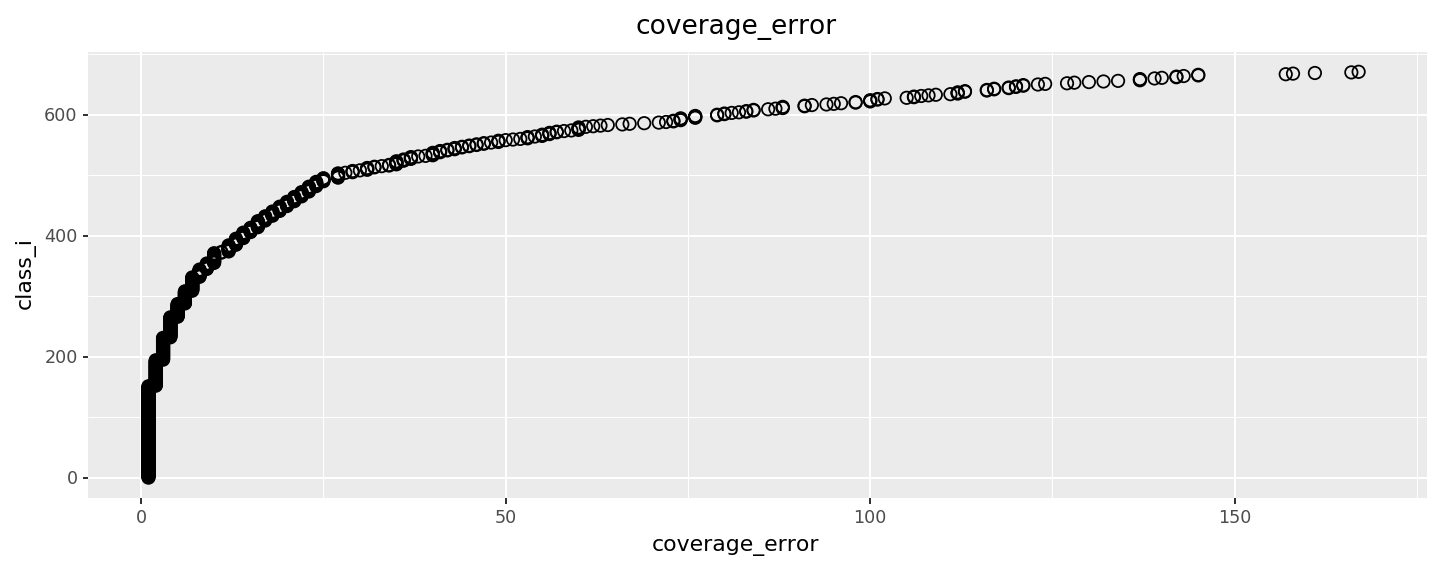

<ggplot: (-9223372036519386245)>

In [ ]:
(
    DF(dict(coverage_error=test_evals.coverage_errors()))
    .sort_values('coverage_error',
        # ascending=False,
    )
    .reset_index(drop=True)
    .reset_index().rename(columns={'index': 'class_i'})
    .pipe(ggplot)
    + aes(y='coverage_error', x='class_i')
    + geom_point(fill='none', size=3)
    + expand_limits(y=n_classes)
    + coord_flip()
    + theme_figsize('inline_short')
    + ggtitle('coverage_error')
)

/Users/danb/hack/bubo/features/viz.py:195: RuntimeWarning: invalid value encountered in true_divide
  M = M.astype('float') / M.sum(axis=1)[:, np.newaxis]


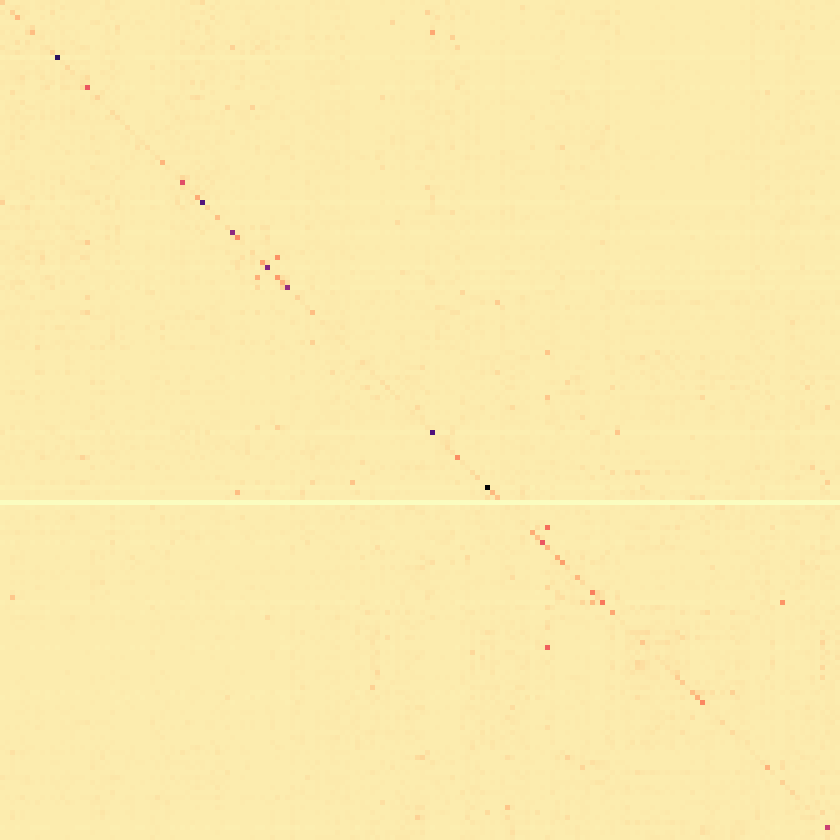

In [ ]:
plot_confusion_matrix_df(
    test_evals.confusion_matrix_prob_df(),
    raw=True, scale=5,
)